In [19]:
import datetime as dt
import pytz
from googleapiclient.errors import HttpError
from authenticate import authenticate_google_calendar 
import matplotlib.pyplot as plt

def get_all_studying_hours_today(service, calendar_id):
    # Get the current local timezone
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo

    # Get today's date in the correct format
    today_start = dt.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone).isoformat()
    today_end = dt.datetime.now().replace(hour=23, minute=59, second=59, microsecond=999999, tzinfo=local_timezone).isoformat()
    
    # Fetch events happening today
    try:
        events_result = service.events().list(calendarId=calendar_id, timeMin=today_start, timeMax=today_end, singleEvents=True, orderBy='startTime').execute()
    except HttpError as error:
        print(f"An error occurred: {error}")
        return
    
    events = events_result.get('items', [])
    
    if not events:
        print("No events found for today.")
        return
    
    # Calculate total studying hours
    total_hours = 0
    for event in events:
        start = event['start'].get('dateTime', event['start'].get('date'))
        end = event['end'].get('dateTime', event['end'].get('date'))
        start_time = dt.datetime.fromisoformat(start)
        end_time = dt.datetime.fromisoformat(end)
        duration = end_time - start_time
        total_hours += duration.total_seconds() / 3600
    
    print(f"Total studying hours scheduled for today: {total_hours:.1f} hours")
    return total_hours

def get_studying_hours_completed_today(service, calendar_id):
    # Get the current local timezone
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo

    # Get today's date for the start of the day and current time
    today_start = dt.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone).isoformat()
    now = dt.datetime.now(tz=local_timezone).isoformat()

    # Fetch events happening today up until now
    try:
        events_result = (
            service.events()
            .list(
                calendarId=calendar_id,
                timeMin=today_start,
                timeMax=now,
                singleEvents=True,
                orderBy="startTime",
                maxResults=10000,
            )
            .execute()
        )
    except HttpError as error:
        print(f"An error occurred: {error}")
        return

    events = events_result.get('items', [])

    if not events:
        print("No events found for today.")
        return 0

    # Calculate total studying hours
    total_hours = 0
    for event in events:
        start = event['start'].get('dateTime', event['start'].get('date'))
        end = event['end'].get('dateTime', event['end'].get('date'))
        start_time = dt.datetime.fromisoformat(start)
        end_time = dt.datetime.fromisoformat(end)
        # Ensure the event has ended before adding to total hours
        if end_time <= dt.datetime.now(tz=local_timezone):
            duration = end_time - start_time
            total_hours += duration.total_seconds() / 3600

    print(f"Total studying hours completed today: {total_hours:.1f} hours")
    return total_hours

In [20]:
def fetch_daily_studying_hours(service, calendar_id, date):
    local_timezone = dt.datetime.now(dt.timezone.utc).astimezone().tzinfo
    start_of_day = date.replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=local_timezone).isoformat()
    end_of_day = date.replace(hour=23, minute=59, second=59, microsecond=999999, tzinfo=local_timezone).isoformat()

    # Attempt to fetch events for the specified day
    try:
        events_result = (
            service.events()
            .list(
                calendarId=calendar_id,
                timeMin=start_of_day,
                timeMax=end_of_day,
                singleEvents=True,
                orderBy="startTime",
                maxResults=10000,
            )
            .execute()
        )
    except HttpError as error:
        print(f"An error occurred: {error}")
        return 0  # Return 0 hours if an error occurs

    events = events_result.get('items', [])
    total_hours = 0
    for event in events:
        start = event['start'].get('dateTime', event['start'].get('date'))
        end = event['end'].get('dateTime', event['end'].get('date'))
        # Parse the datetime strings into datetime objects
        start_time = dt.datetime.fromisoformat(start)
        end_time = dt.datetime.fromisoformat(end)
        # Calculate duration in hours
        duration = (end_time - start_time).total_seconds() / 3600
        total_hours += duration

    return total_hours


In [21]:
import datetime
import plotly.graph_objs as go
def plot_studying_progress(service, calendar_id):
    local_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
    now = datetime.datetime.now(tz=local_timezone)

    # Fetch data for the last week and last month
    monthly_days = 30
    weekly_days = 7
    daily_hours_month = []
    daily_hours_week = []
    dates_month = [now - datetime.timedelta(days=x) for x in range(monthly_days - 1, -1, -1)]
    dates_week = dates_month[weekly_days:]

    for date in dates_month:
        daily_hours = fetch_daily_studying_hours(service, calendar_id, date)
        daily_hours_month.append(daily_hours)
        if date in dates_week:
            daily_hours_week.append(daily_hours)

    # Calculate averages and other statistics
    average_hours_month = sum(daily_hours_month) / monthly_days
    average_hours_week = sum(daily_hours_week) / weekly_days
    max_hours_month = max(daily_hours_month)
    min_hours_month = min(daily_hours_month)
    print(f"Average studying hours over the last month: {average_hours_month:.1f} hours")
    print(f"Average studying hours over the last week: {average_hours_week:.1f} hours")
    
    # Get the total planned and completed studying hours for today
    planned_hours_today = get_all_studying_hours_today(service, calendar_id)
    completed_hours_today = get_studying_hours_completed_today(service, calendar_id)
    percentage_completed = (completed_hours_today / planned_hours_today) * 100
    print(f"Percentage of planned studying hours completed today: {round(percentage_completed)}%")

    # Today's progress
    plt.figure(figsize=(10, 1))
    plt.barh(['Today'], [completed_hours_today], color='skyblue', label='Completed Hours')
    plt.barh(['Today'], [planned_hours_today - completed_hours_today], left=[completed_hours_today], color='lightgrey', label='Remaining Hours')
    plt.xlabel('Hours')
    plt.title('Today\'s Studying Progress')
    plt.legend()

    # Plotting the results for the last month
    plt.figure(figsize=(10, 10))
    plt.barh([date.strftime("%b %d") for date in dates_month], daily_hours_month, color='skyblue')
    plt.xlabel('Date')
    plt.ylabel('Hours Studied')
    plt.title('Studying Hours Over the Last Month')
    plt.axvline(x=average_hours_month, color='green', linestyle='--', label='Monthly Average')
    plt.axvline(x=average_hours_week, color='pink', linestyle='--', label='Weekly Average')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [22]:
calendar_id = '0ca09266015f691eebe0d00c6f3ed7a784713e0160a694b8f7929add00cb1aa1@group.calendar.google.com'
service = authenticate_google_calendar()  

In [23]:
import pandas as pd
import xlsxwriter

# Create the data for the last month.
monthly_days = 30
today = dt.datetime.now()
dates_month = [today - dt.timedelta(days=x) for x in range(monthly_days)]
daily_hours_month = [fetch_daily_studying_hours(service, calendar_id, date) for date in dates_month]

# Data for today
planned_hours_today = get_all_studying_hours_today(service, calendar_id)
completed_hours_today = get_studying_hours_completed_today(service, calendar_id)
remaining_hours_today = planned_hours_today - completed_hours_today

# Average calculations
average_hours_month = sum(daily_hours_month) / monthly_days
# Re-create the Pandas DataFrame for the monthly data.
df_monthly = pd.DataFrame({
    'Date': [date.strftime("%Y-%m-%d") for date in dates_month],
    'Hours Studied': daily_hours_month
})

# DataFrame for today's progress.
df_today = pd.DataFrame({
    'Category': ['Completed Hours', 'Remaining Hours'],
    'Hours': [completed_hours_today, remaining_hours_today]
})

excel_path = 'studying.xlsx'

# Re-open the Excel file with a chart using the corrected sheet references and series for the average line
with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
    df_monthly.to_excel(writer, sheet_name='Monthly Data', index=False)
    df_today.to_excel(writer, sheet_name='Today Progress', index=False)
    
    # Access the XlsxWriter workbook and worksheet objects from the dataframe.
    workbook = writer.book
    worksheet_monthly = writer.sheets['Monthly Data']
    worksheet_today = writer.sheets['Today Progress']
    
    # Create a bar chart for the monthly data.
    chart_monthly = workbook.add_chart({'type': 'bar'})
    chart_monthly.add_series({
        'name': 'Hours Studied',
        'categories': ['Monthly Data', 1, 0, monthly_days, 0],
        'values':     ['Monthly Data', 1, 1, monthly_days, 1],
    })
    chart_monthly.set_y_axis({'name': 'Date'})
    chart_monthly.set_x_axis({'name': 'Hours Studied', 'position_axis': 'on_tick'})
    worksheet_monthly.insert_chart('D2', chart_monthly)
    
    # Create a horizontal bar chart for today's progress.
    chart_today = workbook.add_chart({'type': 'bar', 'subtype': 'stacked'})
    chart_today.add_series({
        'name': 'Completed Hours',
        'categories': ['Today Progress', 1, 0, 1, 0],
        'values':     ['Today Progress', 1, 1, 1, 1],
    })
    chart_today.add_series({
        'name': 'Remaining Hours',
        'categories': ['Today Progress', 2, 0, 2, 0],
        'values':     ['Today Progress', 2, 1, 2, 1],
    })

    chart_today.set_y_axis({'name': 'Category'})
    chart_today.set_x_axis({'name': 'Hours', 'position_axis': 'on_tick'})
    worksheet_today.insert_chart('E2', chart_today)
    
    # writer.save()

excel_path


No events found for today.
No events found for today.


TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

Average studying hours over the last month: 1.2 hours
Average studying hours over the last week: 3.9 hours
Total studying hours scheduled for today: 4.8 hours
Total studying hours completed today: 0.0 hours
Percentage of planned studying hours completed today: 0%


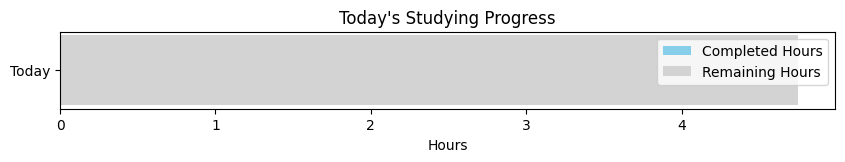

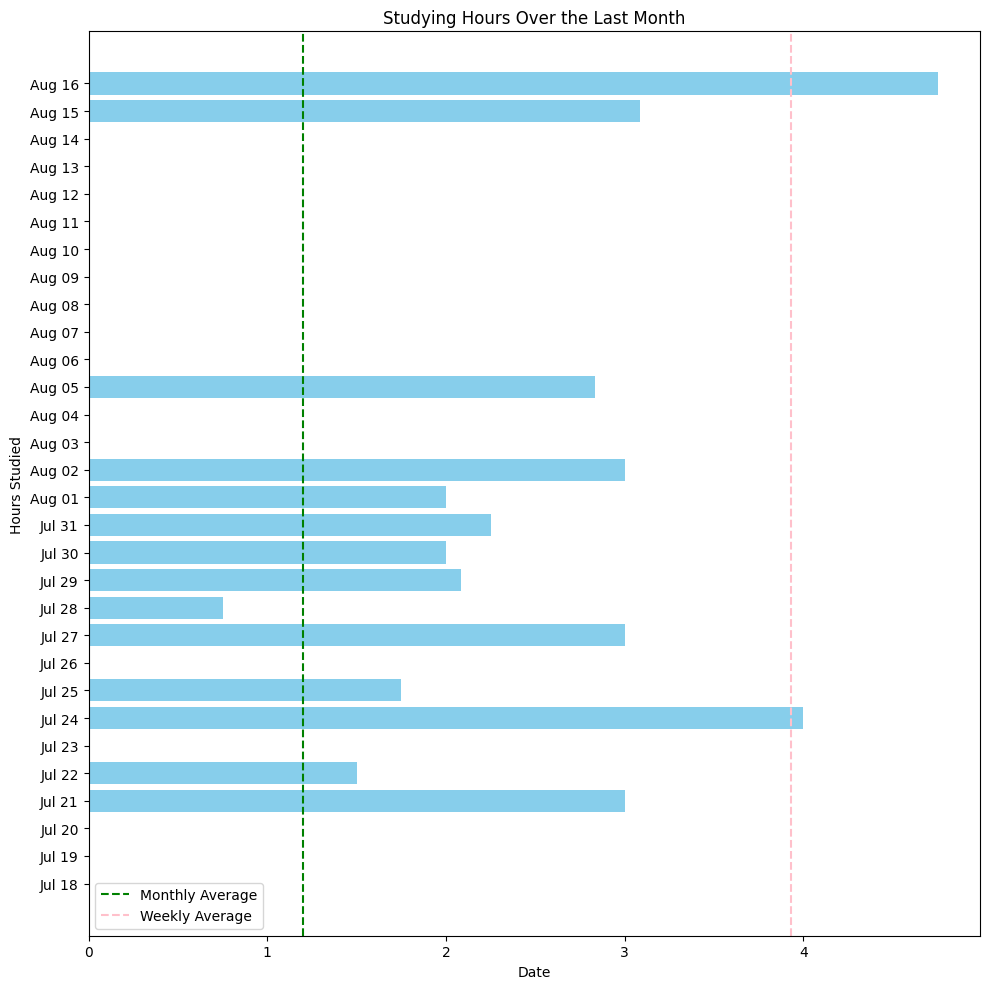

In [6]:

plot_studying_progress(service, calendar_id)  # Replace 'your_calendar_id_here' with your actual studying calendar ID
